# Dataset:
**So we are going to be using the intel-image classification dataset**

In [1]:
# importing the necessary libraries
import os
from PIL import Image
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import pathlib
%matplotlib inline

## Prepping the dataset

In [2]:
data_dir = "../input/intel-image-classification"
train_dir = data_dir + "/seg_train/seg_train"
test_dir = data_dir + "/seg_test/seg_test"
pred_dir = data_dir + "/seg_pred"

In [3]:
# lets look at the classes in the dataset
classes = os.listdir(train_dir)
classes.sort()
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Defining the transforms

In [4]:
train_transform = T.Compose([T.Resize((150,150)), T.ColorJitter(brightness = 1e-2, contrast = 1e-2, saturation = 1e-2, hue = 1e-2), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize((0.3,0.3,0.3),(1,1,1))])
validation_transform = T.Compose([T.Resize((150,150)), T.ToTensor(), T.Normalize((0.3,0.3,0.3),(1,1,1))])
# normalize has been used randomly

# applying the transforms
train_ds = ImageFolder(train_dir, train_transform)
val_ds = ImageFolder(test_dir, validation_transform)

print(len(train_ds))
print(len(val_ds))

14034
3000


In [5]:
train_ds.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [6]:
train_ds.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### Creating the dataloaders

In [7]:
batch_size = 150

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, num_workers = 4, pin_memory = True)

## Let's look at the images in the train set

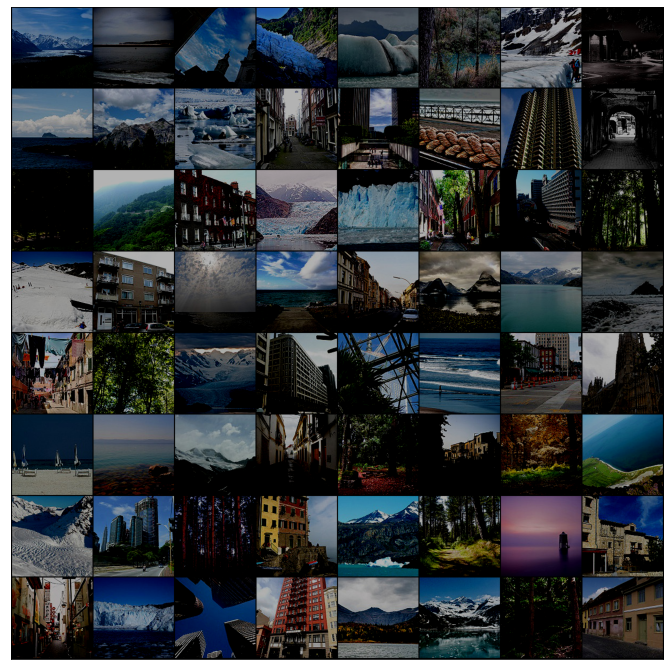

In [8]:
def show_batch(dl):
    for images, labels in dl: 
        
        fig, ax = plt.subplots(figsize = (12, 12))
        
        ax.set_xticks([]); ax.set_yticks([])
        
        ax.imshow(make_grid(images[:64], nrow = 8).permute(1, 2, 0))
        
        break
        
show_batch(train_dl)

### What are the dimensions of these images?

In [9]:
train_iter = iter(train_dl)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([150, 3, 150, 150])
labels shape on batch size = torch.Size([150])


## Models

The basic model : ImageClassificationBase

In [10]:
def accuracy(outputs, labels):
    
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


## Using the Resnet50 pretrained model

In [11]:
class LandscapeCNN(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        
        # Using a pretrained model
        self.network = models.resnet50(pretrained = True)
        
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
    
    
    def forward(self, inpt):
        return torch.sigmoid(self.network(inpt))
    
    
    # freeze function trains the fully connected layer to make predictions
    def freeze(self):
        
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
            
        for param in self.network.fc.parameters():
            param.require_grad = True
            
            
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [12]:
model = LandscapeCNN()
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LandscapeCNN(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

## Transferring the model and the dataloaders to the GPU

In [13]:
def get_default_device():
    
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [14]:
# getting the gpu 
device = get_default_device()
device

device(type='cuda')

In [15]:
# transferring the dataloaders to the GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# transferring the model to the GPU
model = to_device(LandscapeCNN(), device)

In [16]:
# making random predictions
def try_batch(dl):
    
    for images, labels in dl:
        
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([150, 3, 150, 150])
out.shape: torch.Size([150, 6])
out[0]: tensor([0.6995, 0.5077, 0.5805, 0.5189, 0.5376, 0.4812], device='cuda:0',
       grad_fn=<SelectBackward>)


## **Training the Model**

In [17]:
from tqdm.notebook import tqdm

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    
    for param_group in optimizer.param_groups:
        return param_group['lr']  
    

def fit(epochs, max_lr, model, train_loader, val_loader, opt_func, decay, grad_clip = None):
    
    # freeing up space on the GPU
    torch.cuda.empty_cache()
    history = []
    
    # defining the optimizer
    optimizer = opt_func(model.parameters(), lr = max_lr, weight_decay = decay)
    
    # defining the scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))
    
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        
        for batch in tqdm(train_loader):
            
            # calculating the loss and computing gradients
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # using gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # updating the lrs for the epochs
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [19]:
torch.cuda.empty_cache()
# evaluating the model which is randomized
evaluate(model, val_dl)

{'val_loss': 1.7885303497314453, 'val_acc': 0.1899999976158142}

## Training the Model

In [20]:
# freezing the model initially
model.freeze()

In [21]:
max_lr = 1e-2
epochs = 5
opt_func = torch.optim.Adamax
decay = 1e-6
grad_clip = 1e-1
history = []

In [22]:
%%time
history += fit(epochs, max_lr, model, train_dl, val_dl, opt_func, decay, grad_clip)


Epoch [0], last_lr: 0.00757, train_loss: 1.1865, val_loss: 1.4669, val_acc: 0.5077



Epoch [1], last_lr: 0.00950, train_loss: 1.2130, val_loss: 1.2303, val_acc: 0.7730



Epoch [2], last_lr: 0.00611, train_loss: 1.1635, val_loss: 1.1845, val_acc: 0.8303



Epoch [3], last_lr: 0.00188, train_loss: 1.1327, val_loss: 1.1378, val_acc: 0.8853



Epoch [4], last_lr: 0.00000, train_loss: 1.1145, val_loss: 1.1218, val_acc: 0.9067
CPU times: user 1min 21s, sys: 31.3 s, total: 1min 52s
Wall time: 6min 6s


In [23]:
# unfreezing the model
model.unfreeze()
epochs = 3

In [24]:
%%time
history += fit(epochs, max_lr, model, train_dl, val_dl, opt_func, decay, grad_clip)


Epoch [0], last_lr: 0.00994, train_loss: 1.1687, val_loss: 1.4093, val_acc: 0.5660



Epoch [1], last_lr: 0.00463, train_loss: 1.1876, val_loss: 1.1696, val_acc: 0.8360



Epoch [2], last_lr: 0.00000, train_loss: 1.1368, val_loss: 1.1343, val_acc: 0.8907
CPU times: user 49.6 s, sys: 18.3 s, total: 1min 7s
Wall time: 3min 38s


In [25]:
max_lr = 1e-3
epochs = 3

history += fit(epochs, max_lr, model, train_dl, val_dl, opt_func, decay, grad_clip)


Epoch [0], last_lr: 0.00099, train_loss: 1.1226, val_loss: 1.1333, val_acc: 0.8947



Epoch [1], last_lr: 0.00046, train_loss: 1.1206, val_loss: 1.1264, val_acc: 0.8980



Epoch [2], last_lr: 0.00000, train_loss: 1.1124, val_loss: 1.1274, val_acc: 0.9017


In [26]:
max_lr = 1e-4
epochs = 3

history += fit(epochs, max_lr, model, train_dl, val_dl, opt_func, decay, grad_clip)


Epoch [0], last_lr: 0.00010, train_loss: 1.1085, val_loss: 1.1238, val_acc: 0.9030



Epoch [1], last_lr: 0.00005, train_loss: 1.1078, val_loss: 1.1246, val_acc: 0.9023



Epoch [2], last_lr: 0.00000, train_loss: 1.1085, val_loss: 1.1253, val_acc: 0.9027


### Looking at the metrics for our training

#### Accuracies

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

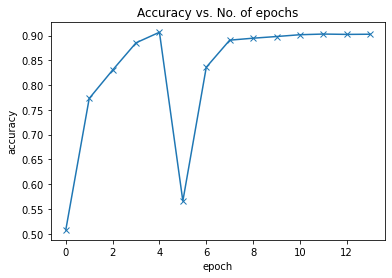

In [28]:
plot_accuracies(history)

#### Losses

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

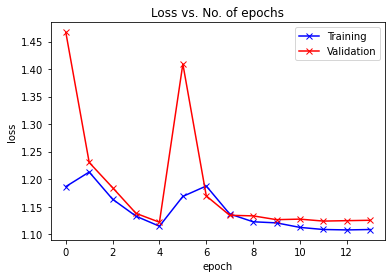

In [30]:
plot_losses(history)

#### Learning Rates

In [31]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

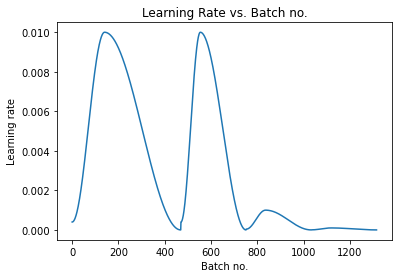

In [32]:
plot_lrs(history)

## Making Predictions

In [33]:
def show_sample(img):
    plt.imshow(img.permute(1, 2, 0))
    
    
# function to predict a single image
def predict(image):
    
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    
    max_ = torch.max(preds[0]).item()
    prediction = classes[(preds[0] == max_).nonzero()]
    
    print("Prediction: ", prediction)
    show_sample(image)

### Getting the dataset for the predictions

In [34]:
pred_ds = ImageFolder(pred_dir, validation_transform)

print(len(pred_ds))

7301


In [35]:
image,target = pred_ds[0]
print(image.shape)

torch.Size([3, 150, 150])


### Looking at individual images and their predictions from our model

Prediction:  mountain


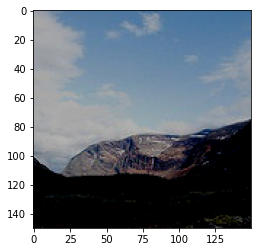

In [36]:
predict(pred_ds[1][0])

Prediction:  mountain


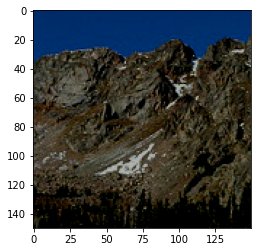

In [37]:
predict(pred_ds[4][0])

Prediction:  street


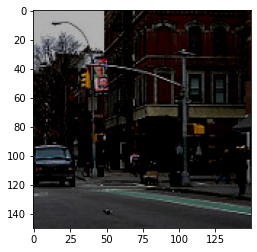

In [38]:
predict(pred_ds[9][0])

Prediction:  street


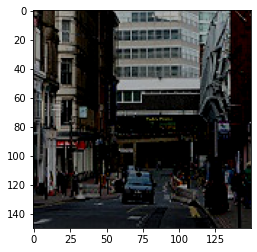

In [39]:
predict(pred_ds[2][0])

Prediction:  glacier


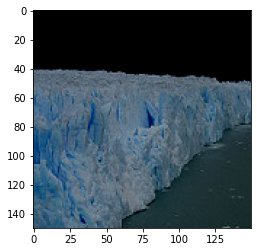

In [40]:
predict(pred_ds[7][0])

### Forming the dataloader for our predictions

In [41]:
# getting the dataloader from the dataset
test_dl = DeviceDataLoader(DataLoader(pred_ds, batch_size, num_workers = 4, pin_memory = True), device)

In [42]:
# getting the predictions for the entire test data loader
def predict_dl(dl, model):
    
    torch.cuda.empty_cache()
    batch_probs = []
    
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        
    batch_probs = torch.cat(batch_probs)
    return [x for x in batch_probs]

In [43]:
test_preds = predict_dl(test_dl, model)

In [44]:
# saving the predictions to the output folder
submissions = pd.DataFrame()
submissions.Label = test_preds
submissions.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


""


In [46]:
# storing our submission into a .csv file
submissions.to_csv("predictions")

In [47]:
!pip install jovian --upgrade

import jovian

jovian.commit(project = "course-project")

     |████████████████████████████████| 63 kB 1.3 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=74b0507b803b0ed7764810dfb9d1f71d8f9f8fe1262a3f8b45481045d9c67774
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/chethan0hebbar/course-project


<IPython.core.display.Javascript object>